In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [8]:
# Convert the date to datetime
df['first_submission_date'] = df['first_submission_date'].apply(
    lambda t: pd.to_datetime(t, unit='s')
)

<Figure size 1500x1000 with 0 Axes>

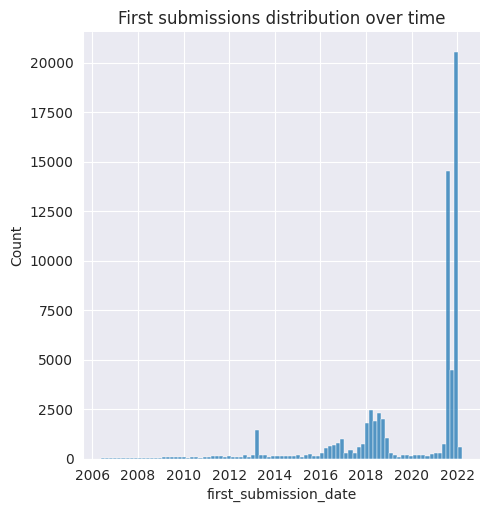

In [9]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
dist_plot = sns.displot(df, x='first_submission_date')
plt.title("First submissions distribution over time")
plt.show()

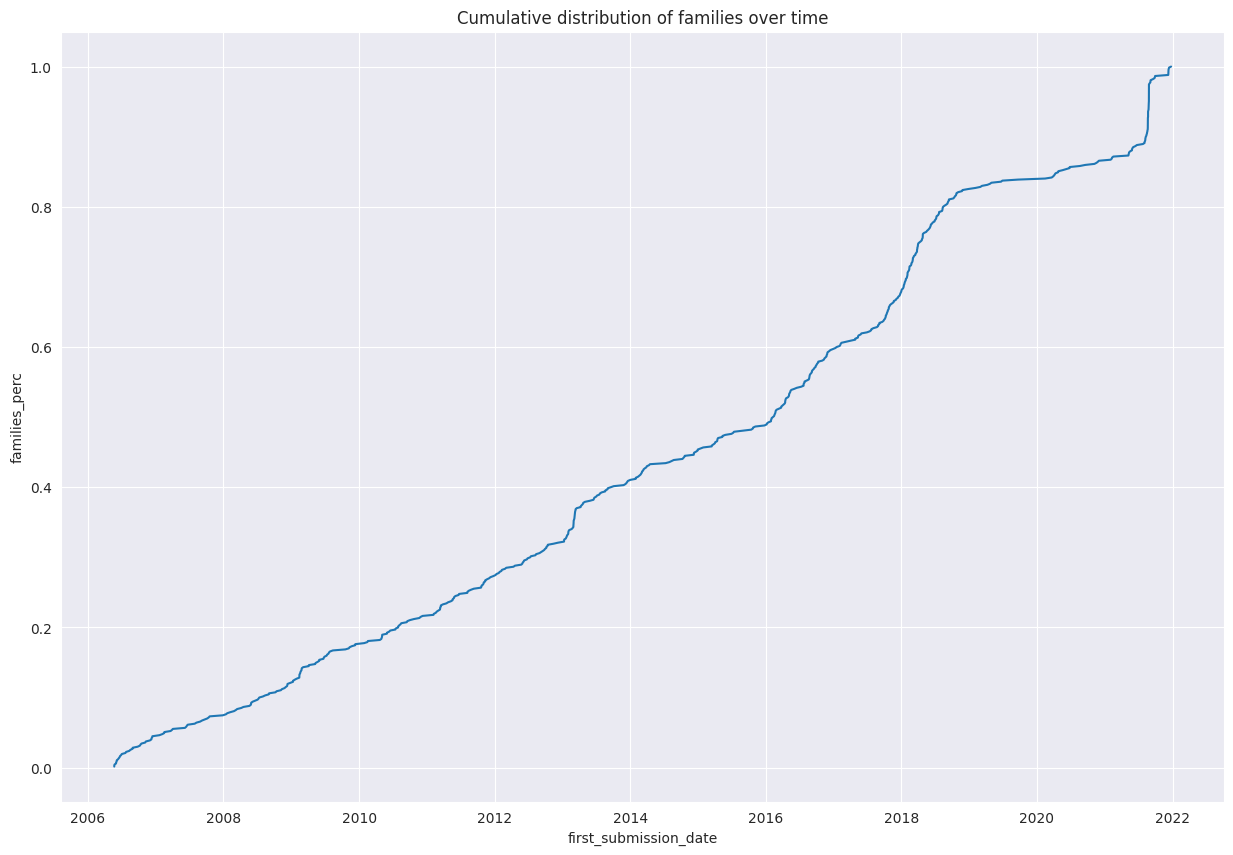

In [6]:
cumulative_df = pd.DataFrame(df[["family", "first_submission_date"]], index=None)

# Group by the rows by the malware family, minimizing the first submission date
cumulative_df = cumulative_df.groupby(by=["family"]).min()

n = len(df)
# For each timestamp, get the number of families previously discovered
cumulative_df['families_perc'] = cumulative_df['first_submission_date'].apply(
    lambda t: len(cumulative_df[cumulative_df['first_submission_date'] <= t]) / n * 100
)

# Sort the submission date in ascending order
cumulative_df = cumulative_df.sort_values(by="first_submission_date")

# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
plt.title("Cumulative distribution of families over time")
sns.lineplot(cumulative_df, x="first_submission_date", y="families_perc")
plt.show()